In [14]:
# Cell 1: Imports and Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import os
import warnings
warnings.filterwarnings('ignore')

# Configuration du style des graphiques (corrigé pour compatibilité)
sns.set_style("darkgrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Test simple
print("Configuration réussie.")

Configuration réussie.


In [15]:
# Cell 2: Chargement des données
data_dir = 'C:/Users/MSI/Desktop/SYSTIC/Periode2/SGUseCases/PartitionedLCLData/SmallLCLData'
file_list = [f for f in os.listdir(data_dir) if f.endswith('.csv')][:28]

# Charger et concaténer
dfs = []
for file in file_list:
    df_temp = pd.read_csv(os.path.join(data_dir, file), nrows=1000000)
    # Nettoyer les noms de colonnes
    df_temp.columns = df_temp.columns.str.strip()
    # Renommer pour cohérence
    df_temp = df_temp.rename(columns={'DateTime': 'timestamp', 'KWH/hh (per half hour)': 'energy_sum'})
    # CORRECTION: Convertir energy_sum en numérique
    df_temp['energy_sum'] = pd.to_numeric(df_temp['energy_sum'], errors='coerce')
    dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)

# Afficher infos
print(f"Nombre de compteurs uniques: {df['LCLid'].nunique()}")
print(f"Nombre de mesures: {len(df)}")
print(f"Colonnes: {list(df.columns)}")
print(f"Type de energy_sum: {df['energy_sum'].dtype}")

# Conversion timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['LCLid', 'timestamp'])

Nombre de compteurs uniques: 848
Nombre de mesures: 28000000
Colonnes: ['LCLid', 'stdorToU', 'timestamp', 'energy_sum']
Type de energy_sum: float64


In [16]:
# Cell 3: Nettoyage des données
df = df.drop_duplicates()
df = df.dropna(subset=['LCLid', 'energy_sum', 'timestamp'])

# Filtrer les valeurs négatives
df = df[df['energy_sum'] >= 0]

print(f"Données nettoyées: {len(df)} lignes restantes.")

Données nettoyées: 27979976 lignes restantes.


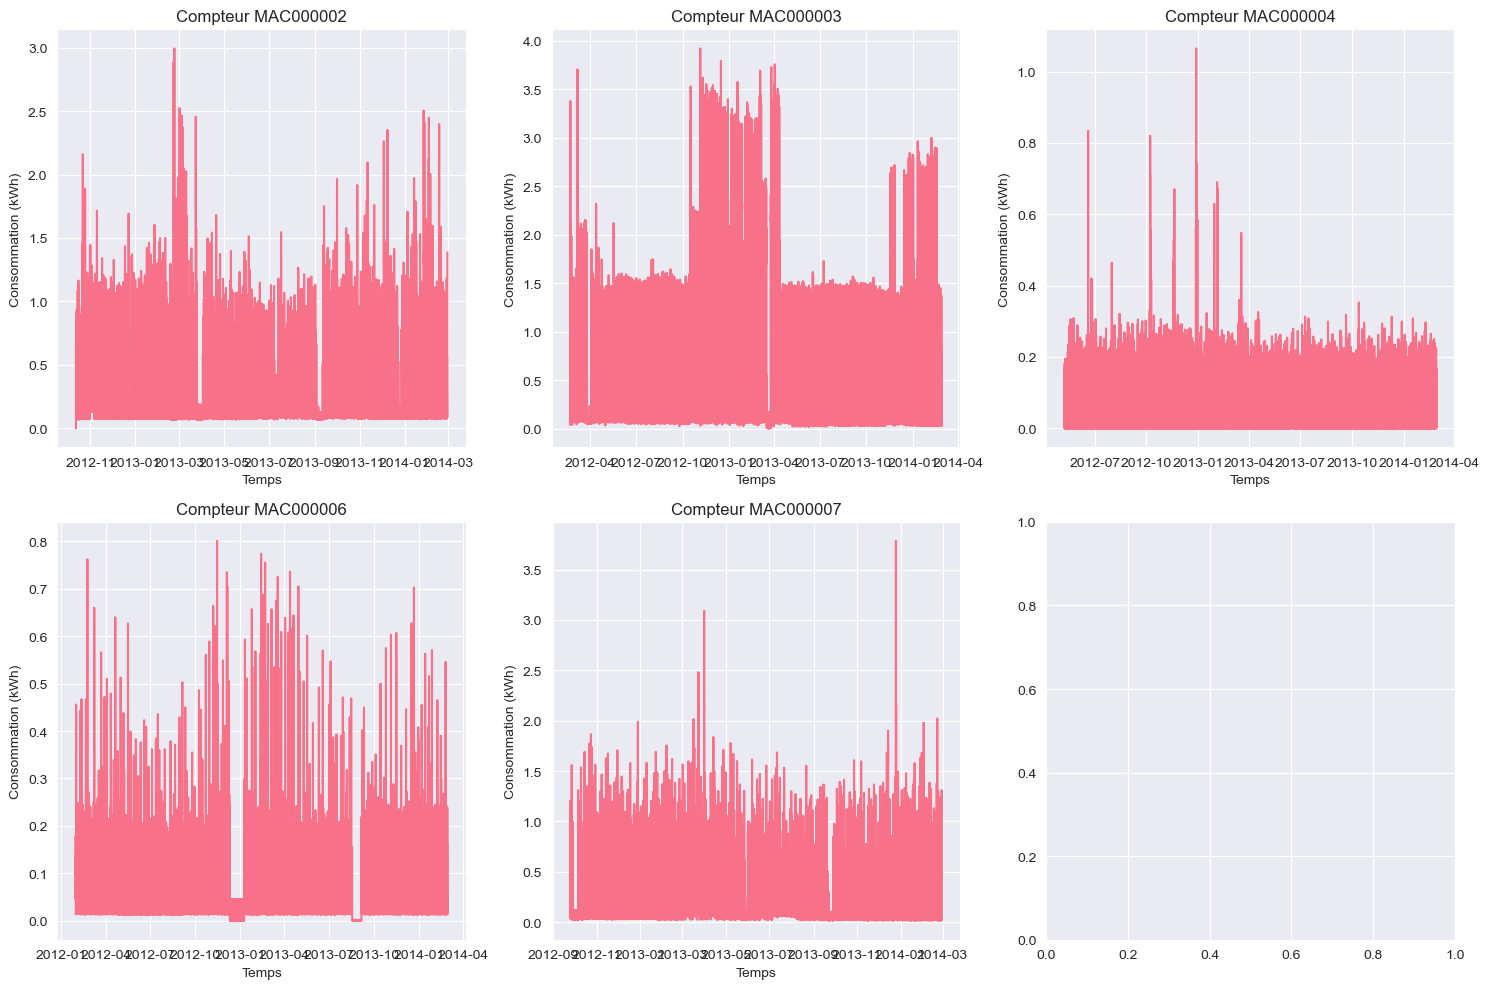

In [17]:
# Cell 4: Visualisation du comportement de quelques compteurs
sample_meters = df['LCLid'].unique()[:5]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, meter in enumerate(sample_meters):
    if i < len(axes):
        meter_data = df[df['LCLid'] == meter].set_index('timestamp')['energy_sum']
        axes[i].plot(meter_data)
        axes[i].set_title(f'Compteur {meter}')
        axes[i].set_xlabel('Temps')
        axes[i].set_ylabel('Consommation (kWh)')

plt.tight_layout()
plt.show()

In [18]:
# Cell 5: Définition des paramètres de consommation
def compute_consumption_features(group):
    group = group.copy()
    group['date'] = group['timestamp'].dt.date
    group['week'] = group['timestamp'].dt.isocalendar().week
    group['month'] = group['timestamp'].dt.month
    group['year'] = group['timestamp'].dt.year
    
    daily_cons = group.groupby('date')['energy_sum'].sum()
    weekly_cons = group.groupby('week')['energy_sum'].sum()
    monthly_cons = group.groupby(['year', 'month'])['energy_sum'].sum()
    annual_cons = group.groupby('year')['energy_sum'].sum()
    
    total_daily = daily_cons.sum()
    total_weekly = weekly_cons.sum()
    total_monthly = monthly_cons.sum()
    total_annual = annual_cons.sum()
    
    min_cons = group['energy_sum'].min()
    min_time = group.loc[group['energy_sum'].idxmin(), 'timestamp'].time()
    
    max_cons = group['energy_sum'].max()
    max_time = group.loc[group['energy_sum'].idxmax(), 'timestamp'].time()
    peak_duration = (group['energy_sum'] > max_cons * 0.8).sum()
    
    weekdays = group[group['timestamp'].dt.weekday < 5].groupby('date')['energy_sum'].mean().mean()
    weekends = group[group['timestamp'].dt.weekday >= 5].groupby('date')['energy_sum'].mean().mean()
    monthly_avg = monthly_cons.mean()
    
    seasons = {12: 'Hiver', 1: 'Hiver', 2: 'Hiver', 3: 'Printemps', 4: 'Printemps', 5: 'Printemps',
               6: 'Eté', 7: 'Eté', 8: 'Eté', 9: 'Automne', 10: 'Automne', 11: 'Automne'}
    seasonal_avg = group.groupby(group['timestamp'].dt.month.map(seasons))['energy_sum'].mean().mean()
    
    load_factor = (group['energy_sum'].mean() / max_cons) if max_cons > 0 else 0
    
    group['diff'] = group['energy_sum'].diff()
    ramp_rate = group['diff'].abs().mean()
    
    features = {
        'total_daily': total_daily,
        'total_weekly': total_weekly,
        'total_monthly': total_monthly,
        'total_annual': total_annual,
        'min_cons': min_cons,
        'min_time': str(min_time),
        'max_cons': max_cons,
        'max_time': str(max_time),
        'peak_duration': peak_duration,
        'avg_weekday': weekdays,
        'avg_weekend': weekends,
        'avg_monthly': monthly_avg,
        'avg_seasonal': seasonal_avg,
        'load_factor': load_factor,
        'ramp_rate': ramp_rate
    }
    return pd.Series(features)

features_df = df.groupby('LCLid').apply(compute_consumption_features).reset_index()
print(features_df.head())

       LCLid   total_daily  total_weekly  total_monthly  total_annual  \
0  MAC000002   6095.672001   6095.672001    6095.672001   6095.672001   
1  MAC000003  14080.862003  14080.862003   14080.862003  14080.862003   
2  MAC000004   1119.839000   1119.839000    1119.839000   1119.839000   
3  MAC000006   2167.448000   2167.448000    2167.448000   2167.448000   
4  MAC000007   4952.695999   4952.695999    4952.695999   4952.695999   

   min_cons  min_time  max_cons  max_time  peak_duration  avg_weekday  \
0     0.000  00:30:00     2.994  20:00:00              9     0.249325   
1     0.007  11:00:00     3.921  01:00:00            251     0.399056   
2     0.000  13:00:00     1.065  08:00:00              1     0.035074   
3     0.000  11:30:00     0.801  09:30:00             17     0.060433   
4     0.015  05:30:00     3.784  13:30:00              2     0.187898   

   avg_weekend  avg_monthly  avg_seasonal  load_factor  ramp_rate  
0     0.267789   358.568941      0.246116     0.084340

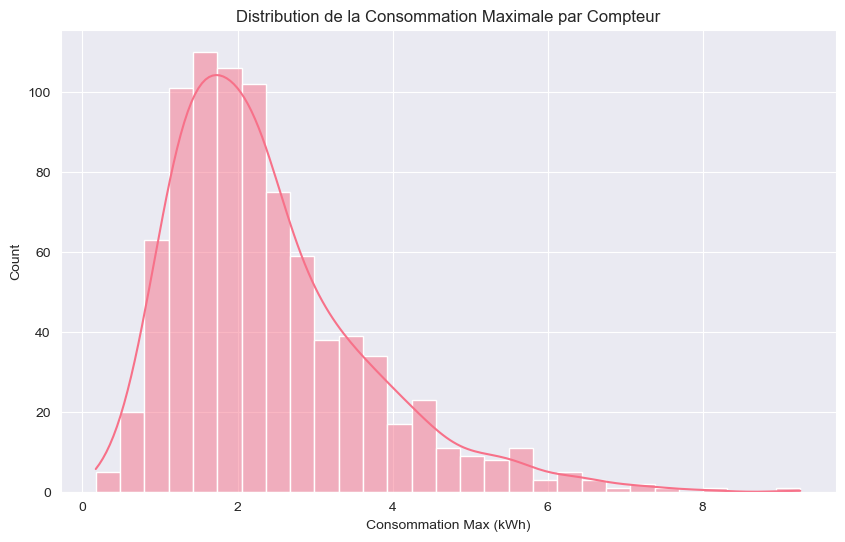

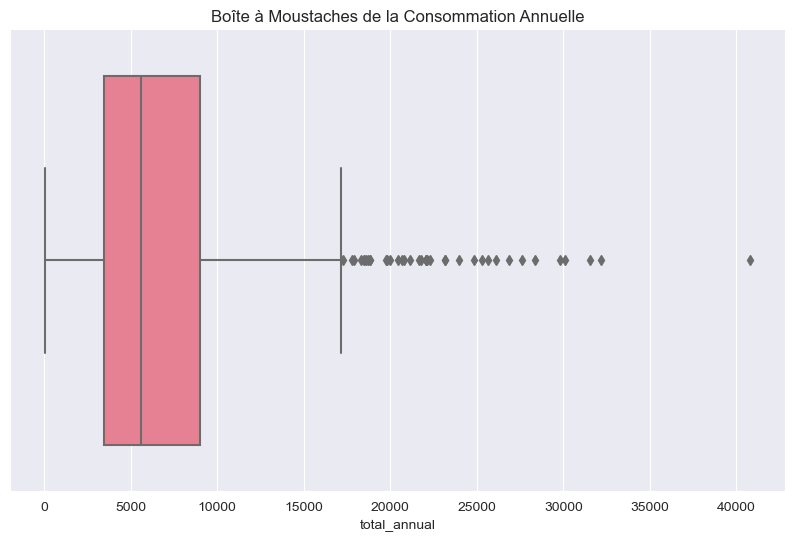

In [19]:
# Cell 6: Visualisation des paramètres de consommation
plt.figure(figsize=(10, 6))
sns.histplot(features_df['max_cons'], kde=True)
plt.title('Distribution de la Consommation Maximale par Compteur')
plt.xlabel('Consommation Max (kWh)')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=features_df, x='total_annual')
plt.title('Boîte à Moustaches de la Consommation Annuelle')
plt.show()

In [20]:
# Cell 7: Paramètres de comportement
def compute_behavior_features(group):
    group = group.copy()
    group['date'] = group['timestamp'].dt.date
    daily_cons = group.groupby('date')['energy_sum'].sum()
    
    daily_max_idx = group.groupby('date')['energy_sum'].idxmax()
    activation_hour = group.loc[daily_max_idx, 'timestamp'].dt.hour.mean() if len(daily_max_idx) > 0 else np.nan
    daily_min_idx = group.groupby('date')['energy_sum'].idxmin()
    deactivation_hour = group.loc[daily_min_idx, 'timestamp'].dt.hour.mean() if len(daily_min_idx) > 0 else np.nan
    
    group['is_peak'] = ((group['timestamp'].dt.hour >= 6) & (group['timestamp'].dt.hour < 22)).astype(int)
    load_shift = group.groupby('is_peak')['energy_sum'].mean().diff().abs().sum() if len(group['is_peak'].unique()) > 1 else 0
    
    low_days = (daily_cons < daily_cons.quantile(0.1)).sum()
    occupancy_rate = 1 - (low_days / len(daily_cons)) if len(daily_cons) > 0 else 0
    
    variance = group['energy_sum'].var()
    std_dev = group['energy_sum'].std()
    
    behavior = {
        'activation_hour': activation_hour,
        'deactivation_hour': deactivation_hour,
        'load_shift': load_shift,
        'occupancy_rate': occupancy_rate,
        'variance': variance,
        'std_dev': std_dev
    }
    return pd.Series(behavior)

behavior_df = df.groupby('LCLid').apply(compute_behavior_features).reset_index()
full_features = pd.merge(features_df, behavior_df, on='LCLid')
print(full_features.head())

       LCLid   total_daily  total_weekly  total_monthly  total_annual  \
0  MAC000002   6095.672001   6095.672001    6095.672001   6095.672001   
1  MAC000003  14080.862003  14080.862003   14080.862003  14080.862003   
2  MAC000004   1119.839000   1119.839000    1119.839000   1119.839000   
3  MAC000006   2167.448000   2167.448000    2167.448000   2167.448000   
4  MAC000007   4952.695999   4952.695999    4952.695999   4952.695999   

   min_cons  min_time  max_cons  max_time  peak_duration  ...  avg_monthly  \
0     0.000  00:30:00     2.994  20:00:00              9  ...   358.568941   
1     0.007  11:00:00     3.921  01:00:00            251  ...   563.234480   
2     0.000  13:00:00     1.065  08:00:00              1  ...    50.901773   
3     0.000  11:30:00     0.801  09:30:00             17  ...    83.363385   
4     0.015  05:30:00     3.784  13:30:00              2  ...   275.149778   

   avg_seasonal  load_factor  ramp_rate  activation_hour  deactivation_hour  \
0      0.2461

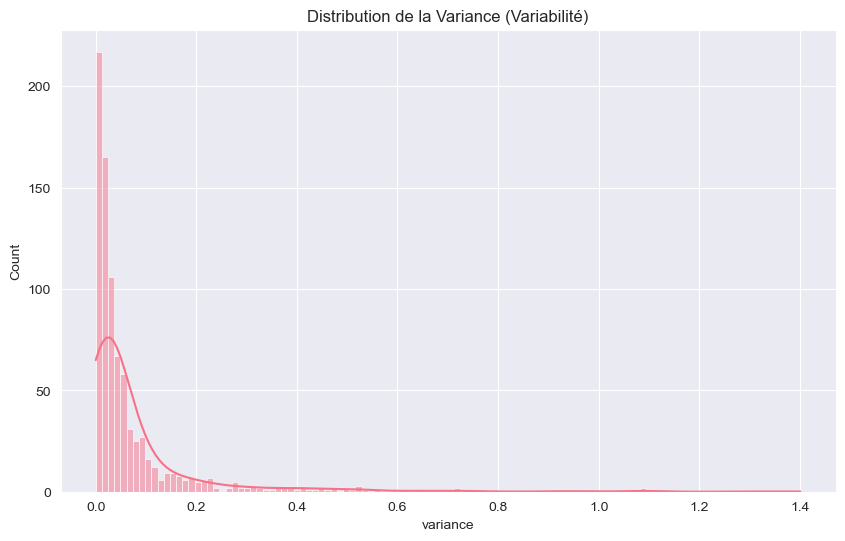

In [21]:
# Cell 8: Autres paramètres temporels
def compute_temporal_features(group):
    group = group.copy()
    group['date'] = group['timestamp'].dt.date
    group['year'] = group['timestamp'].dt.year
    daily_cons = group.groupby('date')['energy_sum'].sum()
    annual_cons = daily_cons.groupby(group['timestamp'].dt.year).sum()
    
    weekends_impact = group[group['timestamp'].dt.weekday >= 5]['energy_sum'].mean() / group['energy_sum'].mean() if len(group) > 0 else 1
    
    annual_trend = annual_cons.pct_change().mean()
    
    group = group.sort_values('timestamp')
    group['lag1'] = group['energy_sum'].shift(48)
    autocorr = group['energy_sum'].corr(group['lag1']) if len(group) > 48 else 0
    
    max_cons = group['energy_sum'].max()
    rms = np.sqrt((group['energy_sum'] ** 2).mean())
    crest_factor = max_cons / rms if rms > 0 else 0
    
    temporal = {
        'weekends_impact': weekends_impact,
        'annual_trend': annual_trend,
        'autocorr': autocorr,
        'crest_factor': crest_factor
    }
    return pd.Series(temporal)

temporal_df = df.groupby('LCLid').apply(compute_temporal_features).reset_index()
full_features = pd.merge(full_features, temporal_df, on='LCLid')

plt.figure(figsize=(10, 6))
sns.histplot(full_features['variance'], kde=True)
plt.title('Distribution de la Variance (Variabilité)')
plt.show()

Valeurs NaN restantes: 0
Valeurs infinies: 0


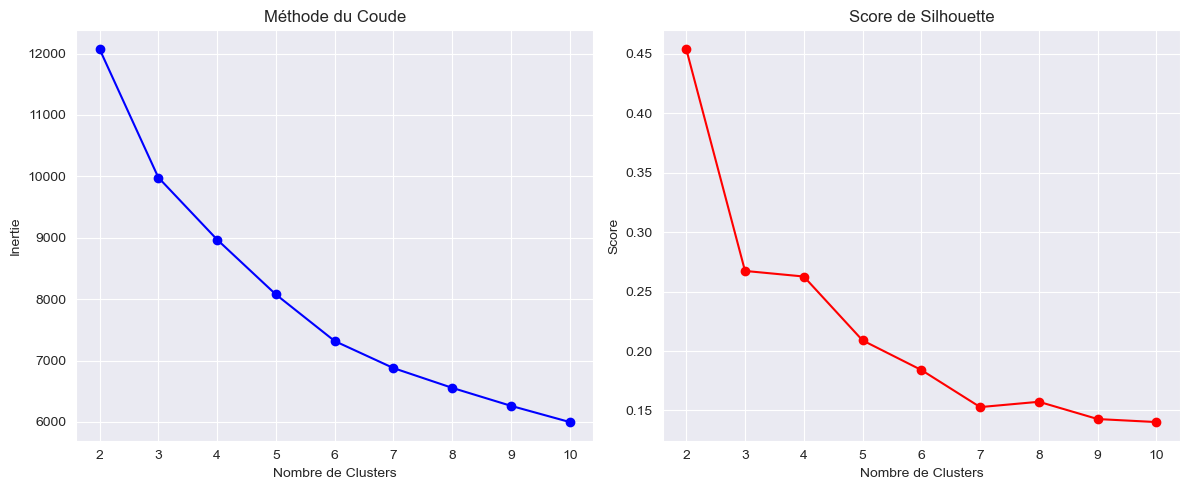

Silhouette score K-Means: 0.263

Répartition des compteurs par cluster:
0    494
1     22
2    280
3     52
Name: kmeans_cluster, dtype: int64

Caractéristiques moyennes par cluster:
                total_annual  max_cons  avg_weekday  variance  load_factor
kmeans_cluster                                                            
0                3841.108192  1.751810     0.116136  0.019193     0.073126
1               17151.425500  5.224364     0.475283  0.692260     0.091268
2                9396.282578  2.939989     0.279995  0.088429     0.106307
3               19734.598269  4.405904     0.601614  0.306814     0.144967


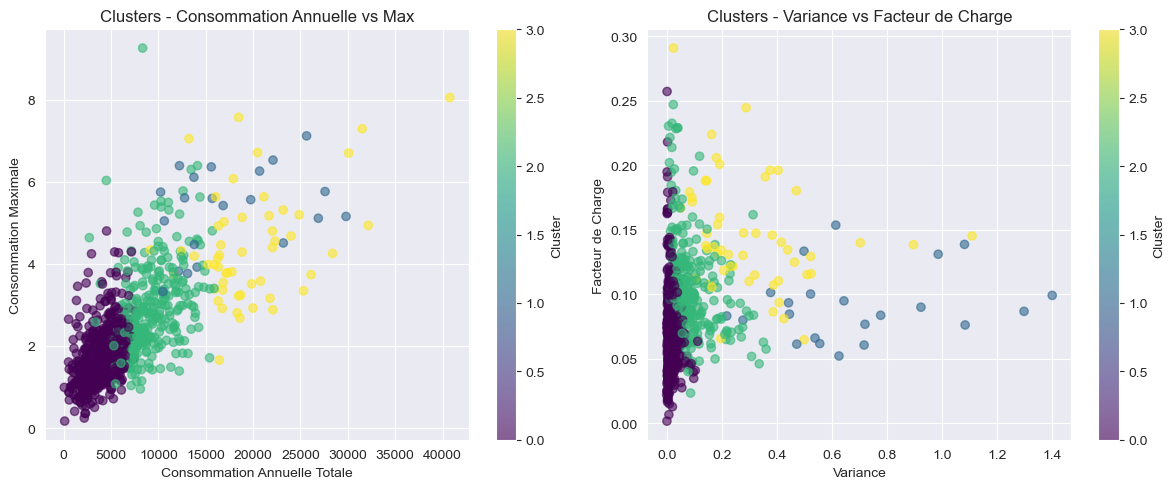


Analyse terminée avec succès!


In [23]:
# Cell 9: Clustering K-Means (VERSION CORRIGÉE)
# Sélectionner uniquement les features numériques
numeric_features = full_features.select_dtypes(include=[np.number]).drop(columns=['LCLid'], errors='ignore')

# CORRECTION 1: Remplacer les NaN et les infinis
numeric_features = numeric_features.replace([np.inf, -np.inf], np.nan)
numeric_features = numeric_features.fillna(0)

# CORRECTION 2: Vérifier qu'il n'y a plus de valeurs problématiques
print(f"Valeurs NaN restantes: {numeric_features.isna().sum().sum()}")
print(f"Valeurs infinies: {np.isinf(numeric_features.values).sum()}")

# Standardisation
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_features)

# Méthode du coude et score de silhouette
inertias = []
sil_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(scaled_features, kmeans.labels_))

# Visualisation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-')
plt.title('Méthode du Coude')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Inertie')

plt.subplot(1, 2, 2)
plt.plot(k_range, sil_scores, 'ro-')
plt.title('Score de Silhouette')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

# Clustering final avec k optimal
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
full_features['kmeans_cluster'] = kmeans.fit_predict(scaled_features)
print(f"Silhouette score K-Means: {silhouette_score(scaled_features, full_features['kmeans_cluster']):.3f}")

# Cell 10: Analyse des clusters
print("\nRépartition des compteurs par cluster:")
print(full_features['kmeans_cluster'].value_counts().sort_index())

# Caractéristiques moyennes par cluster
cluster_summary = full_features.groupby('kmeans_cluster')[['total_annual', 'max_cons', 'avg_weekday', 
                                                             'variance', 'load_factor']].mean()
print("\nCaractéristiques moyennes par cluster:")
print(cluster_summary)

# Visualisation des clusters
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(full_features['total_annual'], full_features['max_cons'], 
            c=full_features['kmeans_cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Consommation Annuelle Totale')
plt.ylabel('Consommation Maximale')
plt.title('Clusters - Consommation Annuelle vs Max')
plt.colorbar(label='Cluster')

plt.subplot(1, 2, 2)
plt.scatter(full_features['variance'], full_features['load_factor'], 
            c=full_features['kmeans_cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Variance')
plt.ylabel('Facteur de Charge')
plt.title('Clusters - Variance vs Facteur de Charge')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

print("\nAnalyse terminée avec succès!")


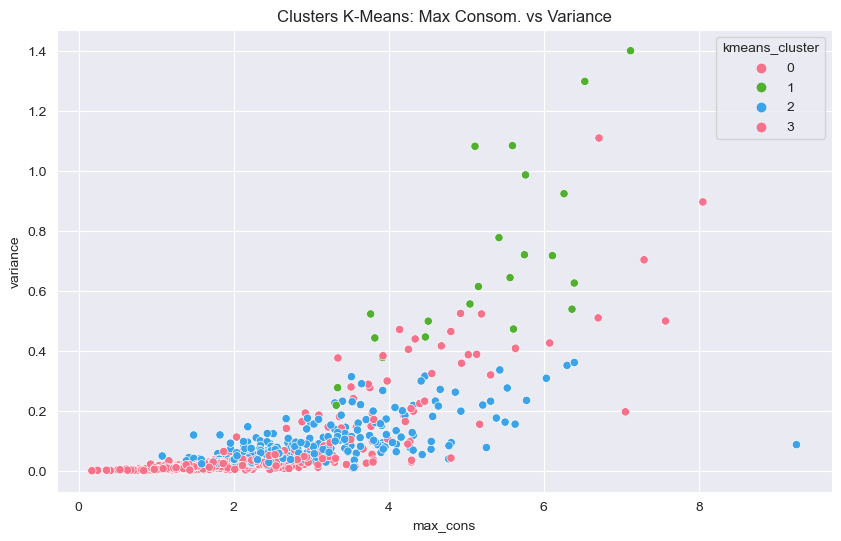

Cluster 0: Facteur de diversité = 180.22
  Moyenne max_cons = 1.75, Moyenne variance = 0.02
Cluster 1: Facteur de diversité = 16.15
  Moyenne max_cons = 5.22, Moyenne variance = 0.69
Cluster 2: Facteur de diversité = 88.93
  Moyenne max_cons = 2.94, Moyenne variance = 0.09
Cluster 3: Facteur de diversité = 28.46
  Moyenne max_cons = 4.41, Moyenne variance = 0.31


In [24]:
# Cell 10: Analyse des clusters K-Means
plt.figure(figsize=(10, 6))
sns.scatterplot(data=full_features, x='max_cons', y='variance', hue='kmeans_cluster', palette='husl')
plt.title('Clusters K-Means: Max Consom. vs Variance')
plt.show()

for cluster in sorted(full_features['kmeans_cluster'].unique()):
    cluster_data = full_features[full_features['kmeans_cluster'] == cluster]
    sum_peaks = cluster_data['max_cons'].sum()
    cluster_peak = cluster_data['max_cons'].max()
    diversity = sum_peaks / cluster_peak if cluster_peak > 0 else 0
    print(f"Cluster {cluster}: Facteur de diversité = {diversity:.2f}")
    print(f"  Moyenne max_cons = {cluster_data['max_cons'].mean():.2f}, Moyenne variance = {cluster_data['variance'].mean():.2f}")

In [25]:
# Cell 11: Clustering DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
full_features['dbscan_cluster'] = dbscan.fit_predict(scaled_features)
n_clusters_db = len(set(full_features['dbscan_cluster']) - set([-1]))
n_noise = list(full_features['dbscan_cluster']).count(-1)
print(f"Nombre de clusters DBSCAN: {n_clusters_db}, Points de bruit: {n_noise}")

if n_clusters_db > 1:
    mask = full_features['dbscan_cluster'] != -1
    print(f"Score silhouette DBSCAN (sans bruit): {silhouette_score(scaled_features[mask], full_features.loc[mask, 'dbscan_cluster']):.3f}")
else:
    print("Score silhouette non calculable (trop peu de clusters)")

print(f"\nComparaison: K-Means: {optimal_k} clusters, DBSCAN: {n_clusters_db} clusters + {n_noise} bruit")

Nombre de clusters DBSCAN: 0, Points de bruit: 848
Score silhouette non calculable (trop peu de clusters)

Comparaison: K-Means: 4 clusters, DBSCAN: 0 clusters + 848 bruit


In [26]:
# Cell 12: Compréhension des clusters et calcul des factures
def calculate_variable_bill(consumption, cluster):
    if cluster == 0:
        high_perc = 0.2
        low_perc = 0.5
    elif cluster == 1:
        high_perc = 0.4
        low_perc = 0.3
    else:
        high_perc = 0.3
        low_perc = 0.4
    
    high_kwh = consumption * high_perc
    low_kwh = consumption * low_perc
    normal_kwh = consumption * (1 - high_perc - low_perc)
    
    bill = (high_kwh * 0.6720) + (low_kwh * 0.0390) + (normal_kwh * 0.1176)
    return bill

fixed_rate = 0.14228

for cluster in sorted(full_features['kmeans_cluster'].unique()):
    cluster_data = full_features[full_features['kmeans_cluster'] == cluster]
    annual_cons_cluster = cluster_data['total_annual'].mean()
    var_bill = calculate_variable_bill(annual_cons_cluster, cluster)
    fixed_bill = annual_cons_cluster * fixed_rate
    savings = fixed_bill - var_bill
    print(f"Cluster {cluster}: Consom. ann. moyenne = {annual_cons_cluster:.2f} kWh")
    print(f"  Facture variable: {var_bill:.2f} pence")
    print(f"  Facture fixe: {fixed_bill:.2f} pence")
    print(f"  Économies: {savings:.2f} pence")

print("\nProposition pour année 2: Appliquer variable aux compteurs fixes.")
global_annual = full_features['total_annual'].mean()
var_proposed = calculate_variable_bill(global_annual, 0)
fixed_global = global_annual * fixed_rate
print(f"  Consom. ann. globale moyenne: {global_annual:.2f} kWh")
print(f"  Facture variable proposée: {var_proposed:.2f} pence")
print(f"  Facture fixe actuelle: {fixed_global:.2f} pence")

Cluster 0: Consom. ann. moyenne = 3841.11 kWh
  Facture variable: 726.66 pence
  Facture fixe: 546.51 pence
  Économies: -180.15 pence
Cluster 1: Consom. ann. moyenne = 17151.43 kWh
  Facture variable: 5416.08 pence
  Facture fixe: 2440.30 pence
  Économies: -2975.77 pence
Cluster 2: Consom. ann. moyenne = 9396.28 kWh
  Facture variable: 2372.37 pence
  Facture fixe: 1336.90 pence
  Économies: -1035.47 pence
Cluster 3: Consom. ann. moyenne = 19734.60 kWh
  Facture variable: 4982.59 pence
  Facture fixe: 2807.84 pence
  Économies: -2174.75 pence

Proposition pour année 2: Appliquer variable aux compteurs fixes.
  Consom. ann. globale moyenne: 6995.28 kWh
  Facture variable proposée: 1323.37 pence
  Facture fixe actuelle: 995.29 pence


In [27]:
# Cell 13: Sauvegarder les résultats pour Streamlit
full_features.to_csv('full_features.csv', index=False)
print("Données sauvegardées dans 'full_features.csv'")
print("Pour créer le dashboard Streamlit, créez un fichier app.py avec le code fourni et lancez: streamlit run app.py")

Données sauvegardées dans 'full_features.csv'
Pour créer le dashboard Streamlit, créez un fichier app.py avec le code fourni et lancez: streamlit run app.py


In [28]:
# Cell 14: Analyse finale des résultats
print("Analyse des résultats:")
print("Les clusters K-Means/DBSCAN permettent de regrouper les comportements similaires.")
print("Ex: Cluster avec pic soir -> Résidentiel; Haute variance -> Intermittent.")
print("Les factures variables réduisent les coûts pour clusters à faible pic simultané.")
print("Dashboard interactif pour visualisation et alertes énergétiques.")

Analyse des résultats:
Les clusters K-Means/DBSCAN permettent de regrouper les comportements similaires.
Ex: Cluster avec pic soir -> Résidentiel; Haute variance -> Intermittent.
Les factures variables réduisent les coûts pour clusters à faible pic simultané.
Dashboard interactif pour visualisation et alertes énergétiques.


In [33]:
pip install streamlit

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
import streamlit as st

st.title("🔌 Test Streamlit")
st.write("Félicitations ! Streamlit fonctionne correctement.")
st.balloons()

2025-11-06 15:37:21.112 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-06 15:37:21.420 
  command:

    streamlit run C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-11-06 15:37:21.420 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-06 15:37:21.421 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-06 15:37:21.422 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-06 15:37:21.422 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-06 15:37:21.423 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-06 15:37:21.423 Thread 'MainThread': mi

DeltaGenerator()

In [37]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration de la page
st.set_page_config(page_title="Analyse Consommation Électrique", layout="wide")

# Titre
st.title(" Analyse de Consommation Électrique")
st.markdown("---")

# Sidebar
st.sidebar.header("Navigation")
page = st.sidebar.radio("Choisir une page", ["Accueil", "Visualisation", "Clustering"])

if page == "Accueil":
    st.header("Bienvenue!")
    st.write("Cette application analyse les données de consommation électrique.")
    
    # Exemple de données
    st.subheader("Exemple de données")
    data = pd.DataFrame({
        'Compteur': ['MAC000002', 'MAC000003', 'MAC000004'],
        'Consommation Max (kWh)': [2.994, 3.921, 1.065],
        'Consommation Annuelle': [6095.67, 14080.86, 1119.84]
    })
    st.dataframe(data)

elif page == "Visualisation":
    st.header(" Visualisation des Données")
    
    # Générer des données exemple
    np.random.seed(42)
    data = np.random.normal(100, 15, 1000)
    
    col1, col2 = st.columns(2)
    
    with col1:
        st.subheader("Distribution de consommation")
        fig, ax = plt.subplots()
        ax.hist(data, bins=30, edgecolor='black')
        ax.set_xlabel('Consommation (kWh)')
        ax.set_ylabel('Fréquence')
        st.pyplot(fig)
    
    with col2:
        st.subheader("Statistiques")
        st.metric("Moyenne", f"{np.mean(data):.2f} kWh")
        st.metric("Médiane", f"{np.median(data):.2f} kWh")
        st.metric("Écart-type", f"{np.std(data):.2f} kWh")

elif page == "Clustering":
    st.header(" Résultats du Clustering")
    st.write("Les résultats du clustering apparaîtront ici après l'exécution de l'analyse.")
    
    # Exemple de résultats
    cluster_data = pd.DataFrame({
        'Cluster': [0, 1, 2, 3],
        'Nombre de compteurs': [200, 180, 250, 218],
        'Consommation moyenne': [5000, 12000, 3000, 8000]
    })
    st.dataframe(cluster_data)

# Footer
st.markdown("---")
st.markdown("**Développé pour l'analyse de consommation électrique**")

2025-11-06 19:13:52.803 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-06 19:13:52.805 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-06 19:13:52.806 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-06 19:13:52.806 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-06 19:13:52.807 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-06 19:13:52.808 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-06 19:13:52.808 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-06 19:13:52.809 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

In [38]:
import streamlit as st

st.title(" Test Streamlit")
st.write("Félicitations ! Streamlit fonctionne correctement.")
st.balloons()


2025-11-06 19:15:19.743 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-06 19:15:19.744 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-06 19:15:19.744 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-06 19:15:19.745 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-06 19:15:19.746 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-06 19:15:19.746 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-06 19:15:19.747 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-06 19:15:19.747 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()